<a href="https://colab.research.google.com/github/arbaazm1/dogbreedID/blob/master/Copy_of_dog_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog Identification App 
---

This app accepts any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.

## Importing Datasets

### Import Dog Dataset

- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing one hot encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [0]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

`human_files` - a numpy array containing file paths.

In [0]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Human Detection

OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) is used to detect human faces in images. 

Number of faces detected: 1


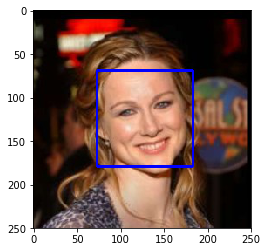

In [0]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

### Human Face Detector

The following function takes a string-valued file path to an image as input and returns `True` if a human face is detected in an image and `False` otherwise.  

In [0]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Human Face Detector Assessment
The following code tests the previously defined face detector function. It calculates the percentage of the first 100 images in `human_files` that have a detected human face and then the percentage of the first 100 images in `dog_files` that have a detected human face.

In [0]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

human_total = 0
dog_total = 0

for humanfile in human_files_short:
    if face_detector(humanfile):
        human_total +=1

for dogfile in dog_files_short:
    if face_detector(dogfile):
        dog_total += 1

print(human_total)
print(dog_total)

99
11


---
## Dog Detection

A pre-trained ResNet-50 model is used to detect dogs in images.

In [0]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Data Preprocessing

In [0]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Predictions with ResNet-50

In [0]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Dog Detector

Categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive. In order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

This is the reasoning behind the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` otherwise).

In [0]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Dog Detector Assessment

The following code tests the previously defined dog detector function. It calculates the percentage of the first 100 images in `human_files_short` that have a detected dog and then the percentage of the first 100 images in `dog_files_short` that have a detected dog. 

In [0]:
human_total = 0
dog_total = 0

for humanfile in human_files_short:
    if dog_detector(humanfile):
        human_total +=1

for dogfile in dog_files_short:
    if dog_detector(dogfile):
        dog_total += 1

print(human_total)
print(dog_total)

1
100


---
## CNN Creation from Scratch to Classify Dog Breeds

The following cells create a CNN from scratch that classifies dog breeds.

### Data Preprocessing

In [0]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:10<00:00, 82.71it/s] 


### Model Architecture

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation="softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Model Compilation

In [0]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Model Training

In [0]:
from keras.callbacks import ModelCheckpoint  

epochs = 50

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/50
6680/6680 [==============================] - 393s - loss: 4.0954 - acc: 0.0940 - val_loss: 4.2513 - val_acc: 0.0647
Epoch 2/50
6680/6680 [==============================] - 394s - loss: 4.0797 - acc: 0.0942 - val_loss: 4.2526 - val_acc: 0.0659
Epoch 3/50
6680/6680 [==============================] - 394s - loss: 4.0700 - acc: 0.0981 - val_loss: 4.3467 - val_acc: 0.0659
Epoch 4/50
6680/6680 [==============================] - 394s - loss: 4.0649 - acc: 0.0930 - val_loss: 4.2451 - val_acc: 0.0754
Epoch 5/50
6680/6680 [==============================] - 393s - loss: 4.0528 - acc: 0.0976 - val_loss: 4.2581 - val_acc: 0.0814
Epoch 6/50
6680/6680 [==============================] - 395s - loss: 4.0417 - acc: 0.1009 - val_loss: 4.2413 - val_acc: 0.0838
Epoch 7/50
6680/6680 [==============================] - 394s - loss: 4.0286 - acc: 0.1006 - val_loss: 4.2277 - val_acc: 0.0838
Epoch 8/50
6680/6680 [==============================] - 393s - l

6680/6680 [==============================] - 360s - loss: 3.8211 - acc: 0.1281 - val_loss: 4.1343 - val_acc: 0.1030
Epoch 31/50
6680/6680 [==============================] - 358s - loss: 3.8109 - acc: 0.1298 - val_loss: 4.0941 - val_acc: 0.1018
Epoch 32/50
6680/6680 [==============================] - 358s - loss: 3.8043 - acc: 0.1308 - val_loss: 4.1089 - val_acc: 0.1054
Epoch 33/50
6680/6680 [==============================] - 359s - loss: 3.7965 - acc: 0.1307 - val_loss: 4.0952 - val_acc: 0.1138
Epoch 34/50
6680/6680 [==============================] - 359s - loss: 3.7906 - acc: 0.1394 - val_loss: 4.1416 - val_acc: 0.0958
Epoch 35/50
6680/6680 [==============================] - 357s - loss: 3.7776 - acc: 0.1331 - val_loss: 4.1471 - val_acc: 0.1006
Epoch 36/50
6680/6680 [==============================] - 358s - loss: 3.7683 - acc: 0.1421 - val_loss: 4.1034 - val_acc: 0.1138
Epoch 37/50
6680/6680 [==============================] - 363s - loss: 3.7628 - acc: 0.1368 - val_loss: 4.1454 - val_

### Load the Model with the Best Validation Loss

In [0]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Model Testing

In [0]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 10.4067%


---
## Transfer Learning to Classify Dog Breeds

### Obtain Bottleneck Features

In [0]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is used as input to the final model.

In [0]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Model Compilation

In [0]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Model Training

In [0]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 4s - loss: 11.5678 - acc: 0.1455 - val_loss: 9.7257 - val_acc: 0.2575
Epoch 2/20
6680/6680 [==============================] - 3s - loss: 9.1006 - acc: 0.3344 - val_loss: 9.0962 - val_acc: 0.3497
Epoch 3/20
6680/6680 [==============================] - 3s - loss: 8.6583 - acc: 0.3996 - val_loss: 8.9314 - val_acc: 0.3521
Epoch 4/20
6680/6680 [==============================] - 3s - loss: 8.4186 - acc: 0.4350 - val_loss: 8.8347 - val_acc: 0.3617
Epoch 5/20
6680/6680 [==============================] - 3s - loss: 8.1334 - acc: 0.4555 - val_loss: 8.6718 - val_acc: 0.3832
Epoch 6/20
6680/6680 [==============================] - 3s - loss: 7.9333 - acc: 0.4704 - val_loss: 8.3868 - val_acc: 0.3988
Epoch 7/20
6680/6680 [==============================] - 3s - loss: 7.6986 - acc: 0.4924 - val_loss: 8.2624 - val_acc: 0.4108
Epoch 8/20
6680/6680 [==============================] - 3s - loss: 7.5891 - a

### Load the Model with the Best Validation Loss

In [0]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Model Testing

In [0]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 47.9665%


### Predict Dog Breed with Model

In [0]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
## CNN to Classify Dog Breeds using Transfer Learning


### Obtain Bottleneck Features

The code block below extracts the bottleneck features corresponding to the train, test, and validation sets.

In [0]:
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

### Model Architecture



In [0]:
### TODO: Define your architecture.
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


### Model Compilation

In [0]:
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Model Training

In [0]:
Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=50, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/50
6680/6680 [==============================] - 5s - loss: 1.6382 - acc: 0.5966 - val_loss: 0.7945 - val_acc: 0.7581
Epoch 2/50
6680/6680 [==============================] - 4s - loss: 0.4362 - acc: 0.8674 - val_loss: 0.7125 - val_acc: 0.7832
Epoch 3/50
6680/6680 [==============================] - 4s - loss: 0.2659 - acc: 0.9120 - val_loss: 0.6502 - val_acc: 0.8060
Epoch 4/50
6680/6680 [==============================] - 4s - loss: 0.1749 - acc: 0.9451 - val_loss: 0.6829 - val_acc: 0.7904
Epoch 5/50
6680/6680 [==============================] - 4s - loss: 0.1274 - acc: 0.9600 - val_loss: 0.7336 - val_acc: 0.7952
Epoch 6/50
6680/6680 [==============================] - 4s - loss: 0.0865 - acc: 0.9719 - val_loss: 0.6807 - val_acc: 0.8216
Epoch 7/50
6680/6680 [==============================] - 4s - loss: 0.0666 - acc: 0.9810 - val_loss: 0.6822 - val_acc: 0.8132
Epoch 8/50
6680/6680 [==============================] - 4s - loss: 0.0481 - ac

6680/6680 [==============================] - 5s - loss: 0.0050 - acc: 0.9988 - val_loss: 1.1449 - val_acc: 0.8204
Epoch 34/50
6680/6680 [==============================] - 5s - loss: 0.0043 - acc: 0.9990 - val_loss: 1.0917 - val_acc: 0.8299
Epoch 35/50
6680/6680 [==============================] - 5s - loss: 0.0055 - acc: 0.9987 - val_loss: 1.1332 - val_acc: 0.8240
Epoch 36/50
6680/6680 [==============================] - 5s - loss: 0.0047 - acc: 0.9985 - val_loss: 1.1692 - val_acc: 0.8228
Epoch 37/50
6680/6680 [==============================] - 5s - loss: 0.0050 - acc: 0.9988 - val_loss: 1.1622 - val_acc: 0.8335
Epoch 38/50
6680/6680 [==============================] - 5s - loss: 0.0047 - acc: 0.9990 - val_loss: 1.1295 - val_acc: 0.8347
Epoch 39/50
6680/6680 [==============================] - 5s - loss: 0.0045 - acc: 0.9988 - val_loss: 1.1930 - val_acc: 0.8287
Epoch 40/50
6680/6680 [==============================] - 5s - loss: 0.0043 - acc: 0.9991 - val_loss: 1.1950 - val_acc: 0.8168
Epoc

### Load the Model with the Best Validation Loss

In [0]:
Resnet50_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Model Testing

In [0]:
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.8182%


### Predict Dog Breed with the Model

The following function takes an image path as input and returns the dog breed that is predicted by the model.  

In [0]:
from extract_bottleneck_features import *

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
## Detection Algorithm

The following algorithm accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, it returns the predicted breed.
- if a __human__ is detected in the image, it returns the resembling dog breed.
- if __neither__ is detected in the image, it provides output that indicates an error.

In [0]:
def breedpred(file):
    if face_detector(file):
        print("I see a human!")
    elif dog_detector(file):
        print("I see a dog!")
    else:
        print("Error. I can't see a dog or a person.")
        return None
    return Resnet50_predict_breed(file)

---
## Algorithm Testing on Sample Images

In [0]:
print(breedpred("dogImages/test/015.Basset_hound/Basset_hound_01044.jpg"))

I see a dog!
Basset_hound


In [0]:
print(breedpred("dogImages/valid/122.Pointer/Pointer_07831.jpg"))

I see a dog!
Pointer


In [0]:
print(breedpred("dogImages/valid/127.Silky_terrier/Silky_terrier_08064.jpg"))

I see a dog!
Silky_terrier


In [0]:
print(breedpred("dogImages/valid/033.Bouvier_des_flandres/Bouvier_des_flandres_02325.jpg"))

I see a dog!
Black_russian_terrier


In [0]:
print(breedpred("peopleImages/jackie-chan-9542080-1-402.jpg"))

I see a human!
Silky_terrier


In [0]:
print(breedpred("peopleImages/luisguzman-thecommies-1.jpg"))

I see a human!
Silky_terrier
